# EDA Samples
## OS/Browser 별 이마트앱 접속 통계 (from Bigquery)

### 1. EDA를 위한 python 및 pydatafabric 모듈 준비
Bigquery를 위한 구체적인 emart 패키지 활용 방법은 링크 참고 (https://emartaiflow.github.io/jupyterbook/bigquery.html)

In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pydatafabric.gcp import bq_to_df, bq_to_pandas

warnings.filterwarnings("ignore")

dt='2022-04-01' # 기준 DATE

### 2. GCP 데이터 검색
- GCP에서 제공하는 Data Catalog를 통해 데이터를 검색할 수 있습니다. (https://console.cloud.google.com/datacatalog?referrer=search&project=emart-datafabric&qSystems=BIGQUERY)

### 3. 원천 데이터 확인
pydatafabric 패키지의 bq_to_df 모듈을 활용해 bigquery table을 load하고, 데이터를 확인할 수 있습니다.
> 내부 엔진으로 Apache Spark을 활용합니다.

목표 EDA를 위해 다음 두 테이블을 load하고 조회해 보겠습니다.
- smart-ruler-304409.o2o_log.ST_LOG

우선 ST_LOG 테이블을 조회 해보겠습니다.

In [3]:
query = f"""
    SELECT
        *
    FROM
        emart-datafabric.common_dev.dfm_sample_st_log
    WHERE
        DATE(insert_dt) = '{dt}'
    LIMIT
        10000
"""

In [4]:
df = bq_to_df(query)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/06 17:05:50 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/06 17:05:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/06 17:05:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/06 17:05:50 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


- ST_LOG 테이블의 스키마를 확인합니다.

In [12]:
df.printSchema()

root
 |-- seq: decimal(38,9) (nullable = true)
 |-- site_code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- guid1: string (nullable = true)
 |-- guid2: string (nullable = true)
 |-- insert_dt: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- os_type: string (nullable = true)
 |-- os_name: string (nullable = true)
 |-- browser_name: string (nullable = true)
 |-- cust_id: string (nullable = true)
 |-- rgst_dt: string (nullable = true)
 |-- rgst_tm: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- refer_url: string (nullable = true)
 |-- tracking_code: string (nullable = true)



In [5]:
df.filter(df["site_code"].isNotNull()).select(df["os_name"], df["browser_name"], df["os_type"]).show(10, False)

+-------+-------------+-------+
|os_name|browser_name |os_type|
+-------+-------------+-------+
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
|Android|Chrome Mobile|A      |
+-------+-------------+-------+
only showing top 10 rows



### 4. 분석 데이터 준비
> 앞서 준비한 테이블을 조회하여 Pandas Dataframe 을 만듭니다.
- 분석에 활용될 데이터 수집을 위해 Query를 작성합니다.

In [6]:
query = f"""
    SELECT
      os_name,
      browser_name,
      COUNT(*) AS cnt
    FROM
      emart-datafabric.common_dev.dfm_sample_st_log
    WHERE
      DATE(insert_dt) = '{dt}'
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 1000000
"""

- Query를 Bigquery 에서 실행하고, 그 결과를 Pandas Dataframe으로 변환하여 저장합니다.

In [7]:
pdf = bq_to_pandas(query)

destination: emart-datafabric._2dd36219768c7c869a5680edf9fd6e104ea57800.anon23d7d1ec90604610b1be935b1ae874a4eb68b380352536c87d5b4b79f40af1f3
total_rows: 11
slot_secs: 0.236



Downloading: 100%|██████████| 11/11 [00:00<00:00, 13.84rows/s]


- pandas로 변환된 데이터를 확인합니다.

In [8]:
pdf.head()

,os_name,browser_name,cnt
0,Android,Android browser,2118
1,iOS,Mobile Safari,700
2,Android,Chrome Mobile,235
3,Windows,Chrome,227
4,OS X,Chrome,74


In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(pdf.describe())

           cnt
count   11.000
mean   313.000
std    633.658
min      2.000
25%      4.000
50%     68.000
75%    231.000
max   2118.000


### 5. OS / Browser 별 접속 분포도
- OS 및 Browser 별 접속 통계를 분포도를 통해 보여줍니다.

<AxesSubplot:xlabel='browser_name', ylabel='cnt'>

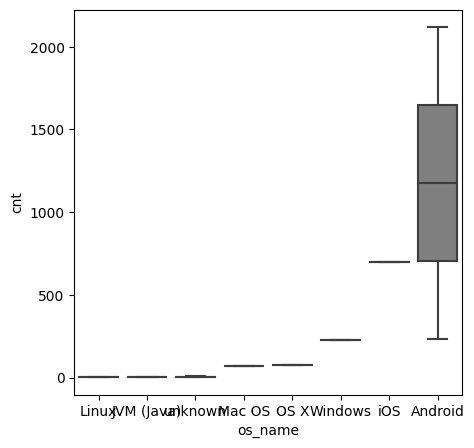

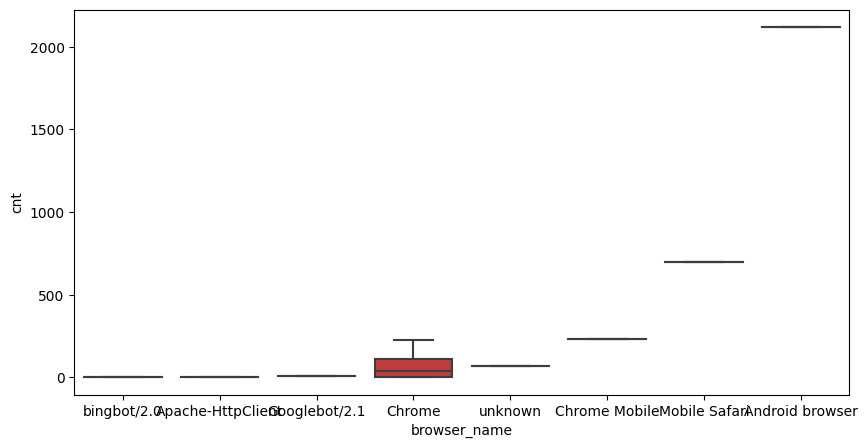

In [10]:
sorted_nb = pdf.groupby(['os_name'])['cnt'].median().sort_values()
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x=pdf['os_name'], y=pdf['cnt'], order=list(sorted_nb.index))

sorted_nb = pdf.groupby(['browser_name'])['cnt'].median().sort_values()
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=pdf['browser_name'], y=pdf['cnt'], order=list(sorted_nb.index))

- OS 와 Browser 의 접속 통계로 보여줍니다.

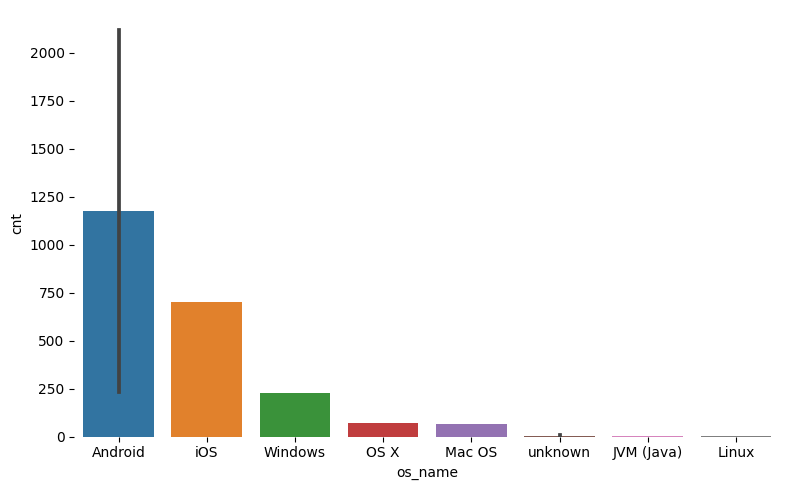

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x="os_name", y="cnt", data=pdf.sort_values(by="cnt", ascending=False))
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

- OS와 Browser의 데이터 분포 상관관계를 통계로 보여줍니다.

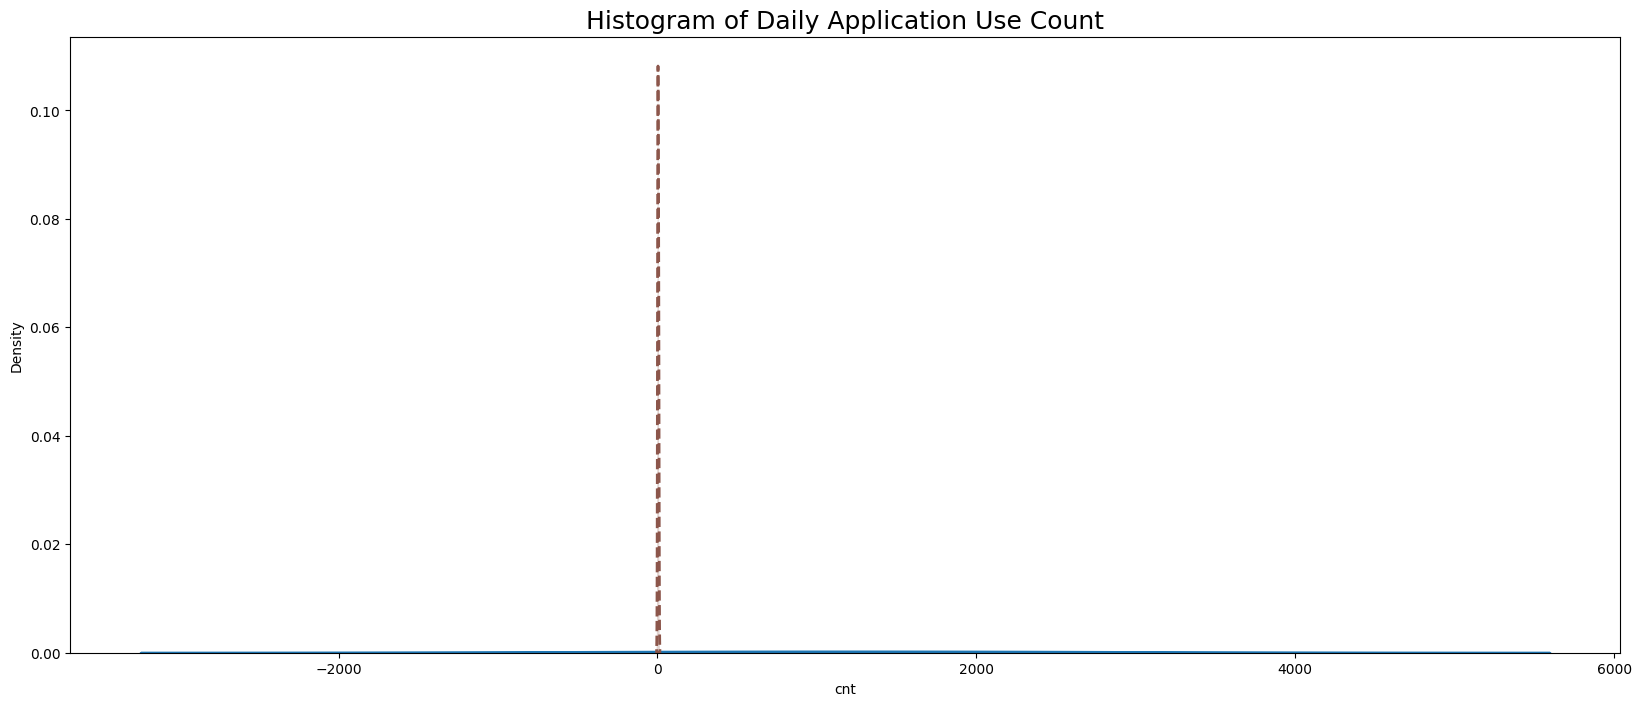

In [12]:
apps = pdf['os_name'].unique().tolist()

LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
plt.figure(figsize=(20,8))
plt.title('Histogram of Daily Application Use Count', fontsize=18)

for i, app_name in enumerate(apps):
    sns_plot = sns.distplot(pdf[pdf['os_name'] == app_name]['cnt'], label=app_name, bins=int(180/5),
            hist=False, kde_kws={'linewidth': 2, 'shade':True, 'linestyle':LINE_STYLES[i % 4]})